In [1]:
import numpy as np
from scipy import signal, interpolate
import quaternion

import matplotlib.pyplot as plt

from copy import copy

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
plt.rcParams['axes.formatter.useoffset'] = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from test_imu_algorithms import IMU_test_data

Set up test data from 0 to 50 seconds at 200Hz

In [4]:
imu = IMU_test_data((0, 50, 1.0/200))

Initial chip orientation

In [5]:
roll0 = np.deg2rad(4) # (-85)
pitch0 = np.deg2rad(9) # (-93)
yaw0 = np.deg2rad(90)

In [6]:
Rx = np.array([[1, 0, 0],
               [0, np.cos(roll0), np.sin(roll0)],
               [0, -np.sin(roll0), np.cos(roll0)]])
Ry = np.array([[np.cos(pitch0), 0, np.sin(pitch0)],
               [0, 1, 0],
               [-np.sin(pitch0), 0, np.cos(pitch0)]])
Rz = np.array([[np.cos(yaw0), np.sin(yaw0), 0],
               [-np.sin(yaw0), np.cos(yaw0), 0],
               [0, 0, 1]])

R0 = Rx.dot(Ry.dot(Rz))
imu.set_initial_orientation(R0)

In [7]:
np.round(R0, decimals=3)

array([[ 0.   ,  0.988,  0.156],
       [-0.998, -0.011,  0.069],
       [ 0.07 , -0.156,  0.985]])

In [8]:
r, p, y = imu._rotm2eul(R0)
print np.rad2deg([r, p, y])

[  4.   9.  90.]


Set up noise parameters

In [9]:
imu.set_noise_params(gyrorms=1.0,          # deg/sec
                     gyrofreq=20.0,        # Hz
                     gyrodriftrms=0.0,     # deg/sec
                     gyrodriftfreq=0.1,    # Hz
                     accrms=0.03,          # g
                     accfreq=33)           # Hz

Generate the arm data

In [10]:
imu.generate_arm_data(alpham=np.deg2rad(15), # 15deg
                      Am=0.15, # 0.15m back and forth
                      f=0.7, # 0.7Hz oscillation
                      l=0.4,
                      delta=0.2) # 20% phase lag between angle and forward back motion

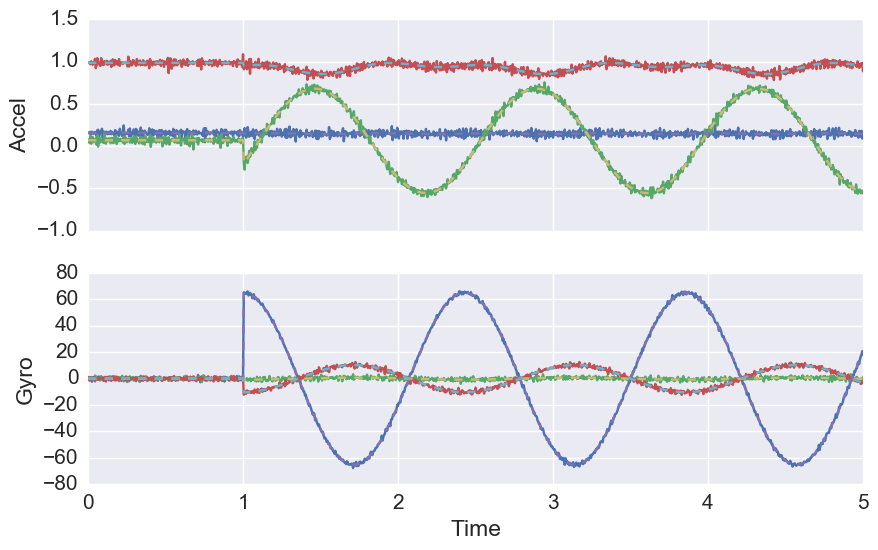

In [11]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(imu.t, imu.acc0)
ax[0].plot(imu.t, imu.acc_nonoise, '--')
ax[0].set_ylabel('Accel')

ax[1].plot(imu.t, imu.gyro0)
ax[1].plot(imu.t, imu.gyro_nonoise, '--')
ax[1].set_ylabel('Gyro')
ax[1].set_xlabel('Time')
ax[0].set_xlim([0, 5])
plt.show()

Set up initial orientation for EKF algorithm

In [12]:
imu.filter(nsamp=10, method='running')

imu.calibrate(duration=30.0)
imu.get_inertial_coords(duration=30.0)
imu.get_world_coordinates(duration=30.0)

/Users/etytel01/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


Check how close the estimated chip orientation is to the real chip orientation

In [13]:
print "Estimated orientation:\n{}".format(np.round(imu.chip2world_rot, decimals=3))
print "\nTrue orientation:\n{}".format(np.round(imu.R0, decimals=3))

print "\nDifference:\n{}".format(np.round(imu.chip2world_rot - imu.R0, decimals=5))
print "\nNorm of difference: {}".format(np.linalg.norm(imu.chip2world_rot - imu.R0))

Estimated orientation:
[[-0.     0.988  0.157]
 [-0.998 -0.011  0.068]
 [ 0.069 -0.156  0.985]]

True orientation:
[[ 0.     0.988  0.156]
 [-0.998 -0.011  0.069]
 [ 0.07  -0.156  0.985]]

Difference:
[[ -4.20000000e-04  -5.00000000e-05   3.30000000e-04]
 [ -3.00000000e-05  -3.80000000e-04  -4.60000000e-04]
 [ -3.90000000e-04  -3.00000000e-04  -2.00000000e-05]]

Norm of difference: 0.000942978520739


In [26]:
imu.get_orientation(method='ekf', lCa=(0.0, -0.3, -0.7))
orient_ekf = copy(imu.orient_world)
orient_ekf_chip = copy(imu.orient_sensor)
accdyn_ekf = copy(imu.accdyn_world)
accdyn_ekf_chip = copy(imu.accdyn_sensor)

In [15]:
imu.filter(method='butter', order=5, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))

dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


In [16]:
imu.get_orientation(method='madgwick')
orient_mad = copy(imu.orient_world)
orient_mad_chip = copy(imu.orient_sensor)
accdyn_mad = copy(imu.accdyn_world)
accdyn_mad_chip = copy(imu.accdyn_sensor)
qorient_mad = copy(imu.qorient)

In [17]:
print "Initial quat orientation:\n{}".format(np.round(quaternion.as_rotation_matrix(
    qorient_mad[0]), decimals=3))
print "Estimated orientation:\n{}".format(np.round(imu.chip2world_rot.T, decimals=3))
print "qchip2world:\n{}".format(np.round(quaternion.as_rotation_matrix(imu.qchip2world.conj()),decimals=3))

Initial quat orientation:
[[-0.    -0.998  0.069]
 [ 0.988 -0.011 -0.156]
 [ 0.157  0.068  0.985]]
Estimated orientation:
[[-0.    -0.998  0.069]
 [ 0.988 -0.011 -0.156]
 [ 0.157  0.068  0.985]]
qchip2world:
[[-0.    -0.998  0.069]
 [ 0.988 -0.011 -0.156]
 [ 0.157  0.068  0.985]]


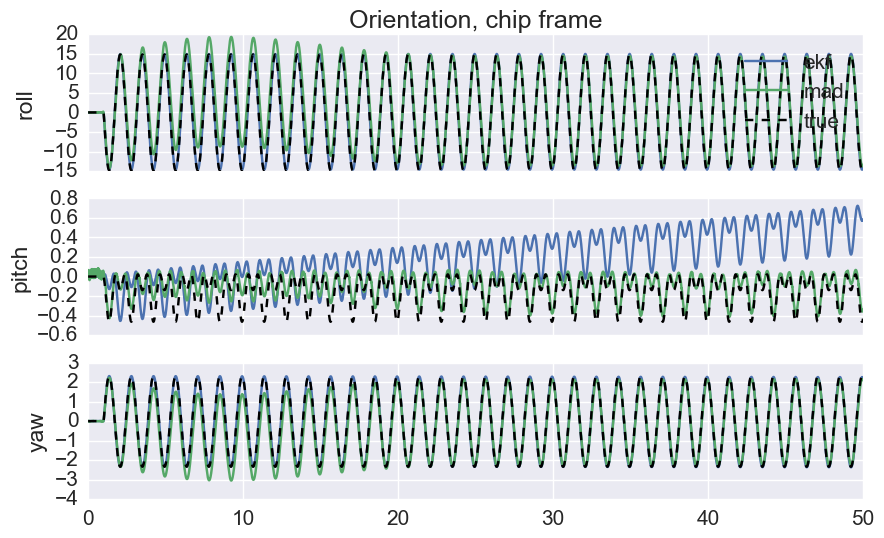

In [18]:
fig, ax = plt.subplots(3,1, sharex=True)
for o0, om, oe, ax1, lab in zip(np.rollaxis(imu.orient_imu_true, 1), 
                                np.rollaxis(orient_mad_chip, 1), 
                                np.rollaxis(orient_ekf_chip, 1),
                                ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, -np.rad2deg(oe), label='ekf')
    ax1.plot(imu.t, np.rad2deg(om), label='mad')
    ax1.plot(imu.t, o0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Orientation, chip frame')
ax[0].legend()
#ax[0].set_xlim([4.5, 5])

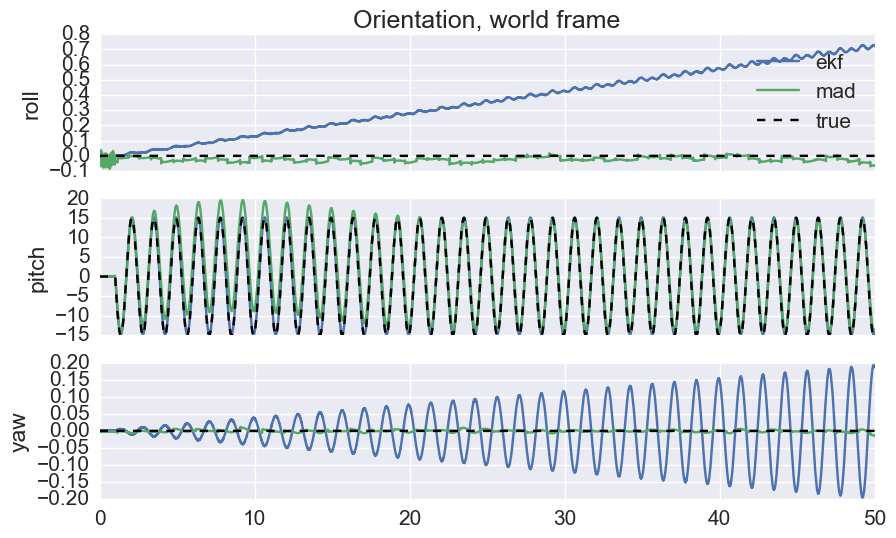

In [19]:
fig, ax = plt.subplots(3,1, sharex=True)
for o0, om, oe, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(orient_mad, 1), 
                                np.rollaxis(orient_ekf, 1),
                                ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(oe), label='ekf')
    ax1.plot(imu.t, np.rad2deg(om), label='mad')
    ax1.plot(imu.t, o0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Orientation, world frame')
ax[0].legend()
#ax[0].set_xlim([4.5, 5])

(10, 12)

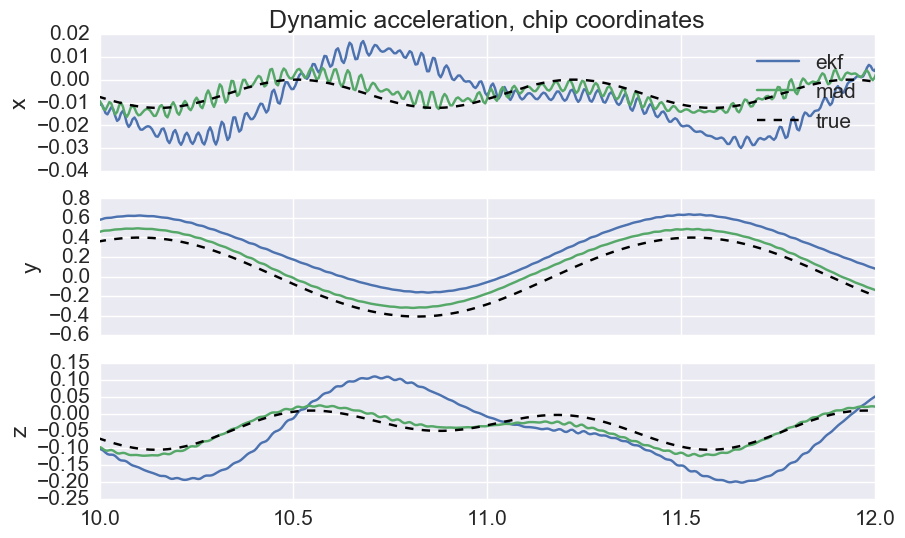

In [27]:
fig, ax = plt.subplots(3,1, sharex=True)
for a0, ae, am, ax1, lab in zip(np.rollaxis(imu.accdyn_imu_true, 1), 
                                    np.rollaxis(accdyn_ekf_chip, 1),
                                    np.rollaxis(accdyn_mad_chip, 1), ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, ae, label='ekf')
    ax1.plot(imu.t, am, label='mad')
    ax1.plot(imu.t, a0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, chip coordinates')
ax[0].legend()
ax[0].set_xlim([10, 12])

(10, 12)

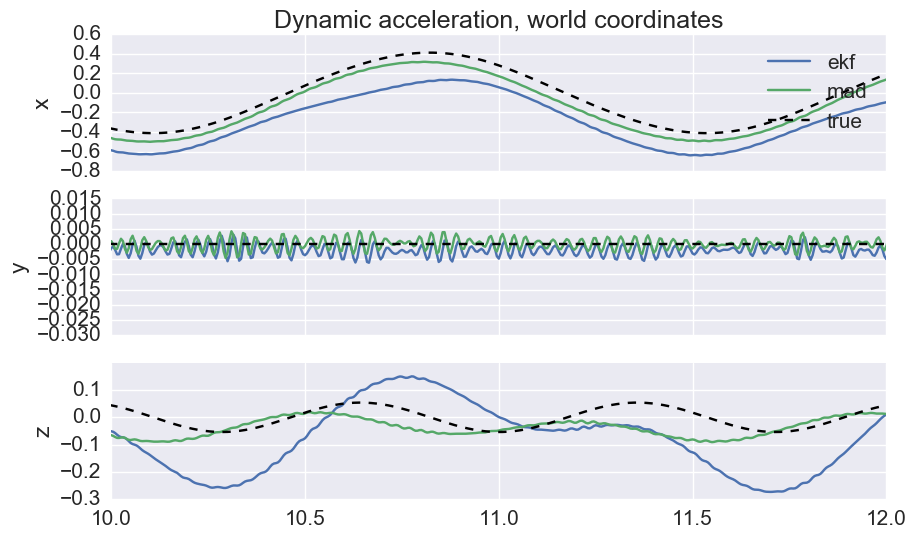

In [29]:
fig, ax = plt.subplots(3,1, sharex=True)
for a0, ae, am, ax1, lab in zip(np.rollaxis(imu.accdyn_world_true, 1), 
                                np.rollaxis(accdyn_ekf, 1),
                                np.rollaxis(accdyn_mad, 1),
                                ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, ae, label='ekf')
    ax1.plot(imu.t, am, label='mad')
    ax1.plot(imu.t, a0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, world coordinates')
ax[0].legend()
ax[0].set_xlim([10, 12])